In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import matplotlib.pyplot as plt

In [5]:
df_total = pd.read_csv('./data/Digit Recognizer/train.csv', dtype = np.float32) # np.float32을 사용하면 메모리 사용량을 줄일 수 있다.
# 각 이미지를 이루는 전체 픽셀의 개수는 784(28×28)개이고, 데이터의 행의 개수는 42,000개.

print(df_total.columns)
print(df_total.index)

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41996,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41997,7.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
41998,6.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [11]:
arr_feature = df_total.loc[:, df_total.columns != 'label'].values/255 # 피처에 255로 나누어 정규화(Normalization).
arr_target = df_total.label.values

arr_feature_train, arr_feature_test, arr_target_train, arr_target_test = train_test_split(arr_feature, arr_target, test_size = 0.2)

# 각 데이터 세트의 데이터 타입을 Tensor로 변경.
ts_feature_train = torch.from_numpy(arr_feature_train)
ts_target_train = torch.from_numpy(arr_target_train).type(torch.LongTensor)
ts_feature_test = torch.from_numpy(arr_feature_test)
ts_target_test = torch.from_numpy(arr_target_test).type(torch.LongTensor)

# 각 데이터 세트별 feature와 label Tensor을 Tensor dataset으로 합친다.
ds_train = torch.utils.data.TensorDataset(ts_feature_train, ts_target_train)
ds_test = torch.utils.data.TensorDataset(ts_feature_test, ts_target_test)

# 훈련 및 테스트 세트의 타입을 Data loader로 변경. Data loader 설정할 때 batch_size와 shuffle 인자에 값을 준다.
batch_size = 256

ldr_train = torch.utils.data.DataLoader(ds_train, batch_size = batch_size, shuffle = True)
ldr_test = torch.utils.data.DataLoader(ds_train, batch_size = batch_size, shuffle = True)

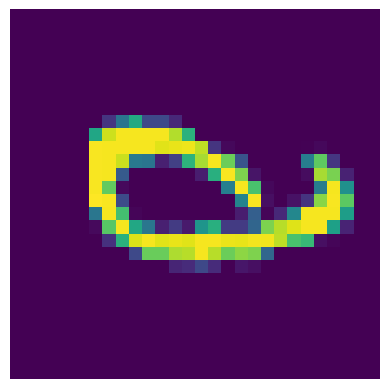

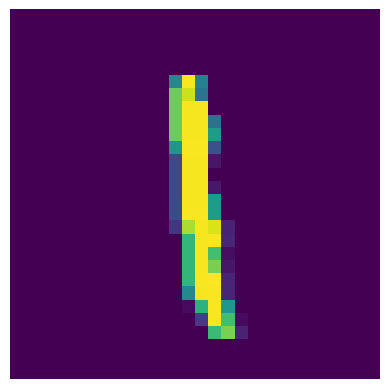

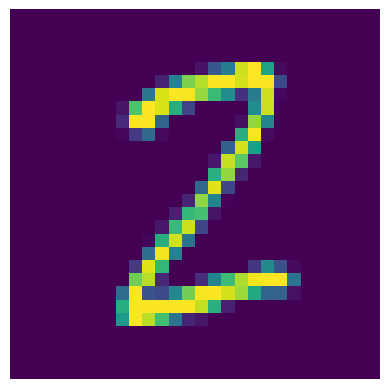

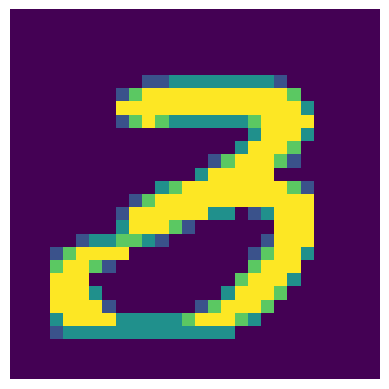

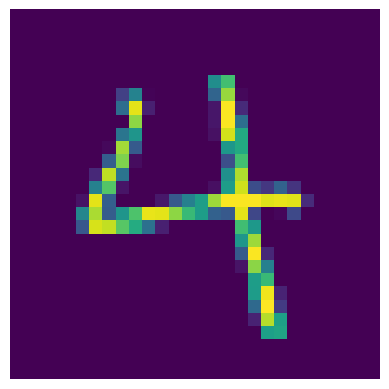

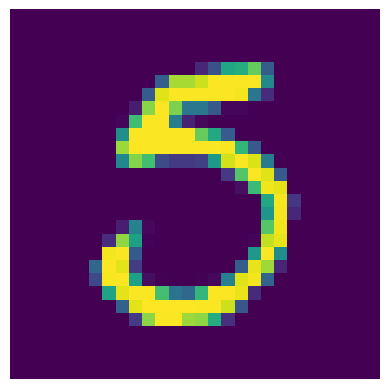

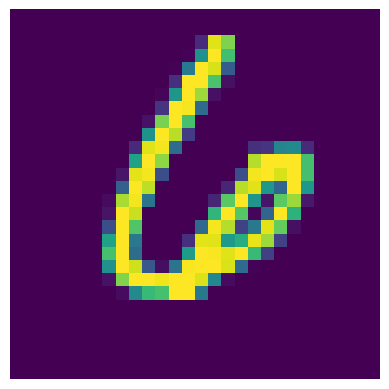

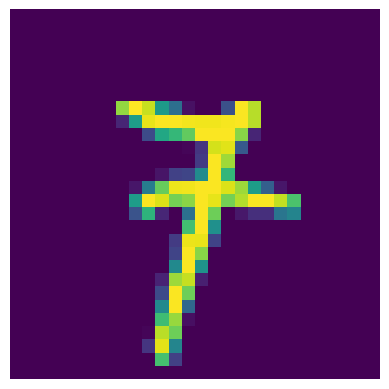

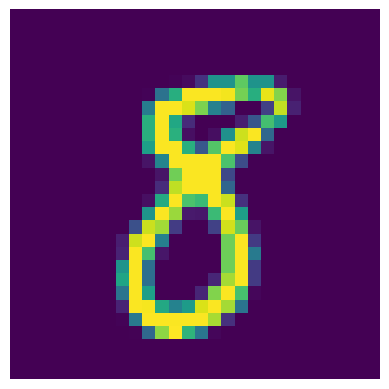

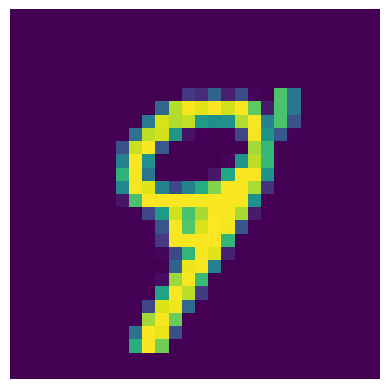

In [10]:
def get_image(data, idx):
    plt.imshow(data[idx].reshape(28, 28))
    plt.axis('off')
    plt.show()

for i in range(10):
    get_image(arr_feature_train, np.where(arr_target_train == i)[0][1])

In [111]:
# Architecture
# Input Layer -> Hidden Layer 1 -> Hidden Layer 2 -> Hidden Layer 3 -> Output Layer

class ANN(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.fc_1 = nn.Linear(28*28, 512) # nn.Linear() 통해 Fully-connected layer을 구성.
        self.fc_2 = nn.Linear(512, 256)
        self.fc_3 = nn.Linear(256, 128)
        self.fc_4 = nn.Linear(128, 64)
        self.fc_5 = nn.Linear(64, 10)
        
        # Dropout을 통해 레이어간 연결 중 일부를 랜덤하게 삭제하여 여러 개의 네트워크를 Ensemble learning 하는 효과를 낼 수 있다.
        self.dropout = nn.Dropout(p = 0.2) # Propagation 과정에 각 노드를 Dropout.
        self.log_softmax = F.log_softmax # softmax 보다 더 빠르고 수치적으로 안정적이라 사용.
        
    def forward(self, x):
        x = self.dropout(F.relu(self.fc_1(x)))
        x = self.dropout(F.relu(self.fc_2(x)))
        x = self.dropout(F.relu(self.fc_3(x)))
        x = self.dropout(F.relu(self.fc_4(x)))
        
        x = self.log_softmax(self.fc_5(x), dim = 1)
        
        return x
    
    def predict(self, x):
        x = self.forward(x)
        return x

In [32]:
model = ANN()
loss_fun = nn.NLLLoss() # log_softmax 계산 결과에 적용하여 cross entropy loss를 구함.
optimizer = optim.Adam(model.parameters(), lr = 0.0001)

In [33]:
epoch = 25
train_loss, test_loss = [], []

for e in range(epoch):

    # (2) 모델 학습
    running_loss_train = 0 # 훈련 세트의 학습 횟수별 오차 기록
    
    for image, label in ldr_train:
        optimizer.zero_grad()
        
        log_pred = model(image)
        loss = loss_fun(log_pred, label)
        
        loss.backward() # 역전파 과정
        optimizer.step() # 모델의 파라미터를 업데이트
        
        running_loss_train += loss.item() # 훈련 세트의 모든 배치 loss.item()을 더하여 전체 오차를 구함.
    
    # (3) 모델 검증
    running_loss_test = 0
    accuracy = 0
    
    with torch.no_grad(): # no_grad() 사용. 모델 검증 과정에서는 저장된 경사도가 필요 없고 메모리 절약 및 연산 속도 증가에 도움.
        model.eval() # 평가모드로 변환.
        
        for image, label in ldr_test:
            log_pred = model(image)
            running_loss_test += loss_fun(log_pred, label) # running_loss_test란 테스트 세트의 학습 횟수별 오차 기록.
            pred = torch.exp(log_pred) # .exp() log_pred를 확률로 변경.
            top_prob, top_class = pred.topk(1, dim = 1) # .topk()를 이용하여 가장 높은 확률을 클래스 예측 결과.
            equal = (top_class == label.view(*top_class.shape)) # .view()는 label과 top_class의 형태를 같게 하기 위해 사용.
            # top_class == label을 통해 예측 결과와 실제 레이블이 같으면 1, 아니면 0이란 결과를 얻은 뒤, 평균을 구하여 정확도를 계산.
            accuracy += torch.mean(equal.type(torch.FloatTensor))
            
    model.train()
    
    train_loss.append(running_loss_train/len(ldr_train))
    test_loss.append(running_loss_test/len(ldr_test))
    
    print("Epoch: {}/{}.. ".format(e + 1, epoch),
          "Training Loss: {:.3f}.. ".format(train_loss[-1]),
          "Test Loss: {:.3f}.. ".format(test_loss[-1]),
          "Test Accuracy: {:.3f}".format(accuracy/len(ldr_test)))

Epoch: 1/25..  Training Loss: 1.899..  Test Loss: 0.932..  Test Accuracy: 0.736
Epoch: 2/25..  Training Loss: 0.804..  Test Loss: 0.470..  Test Accuracy: 0.873
Epoch: 3/25..  Training Loss: 0.539..  Test Loss: 0.358..  Test Accuracy: 0.897
Epoch: 4/25..  Training Loss: 0.440..  Test Loss: 0.307..  Test Accuracy: 0.909
Epoch: 5/25..  Training Loss: 0.385..  Test Loss: 0.282..  Test Accuracy: 0.917
Epoch: 6/25..  Training Loss: 0.354..  Test Loss: 0.253..  Test Accuracy: 0.925
Epoch: 7/25..  Training Loss: 0.317..  Test Loss: 0.229..  Test Accuracy: 0.931
Epoch: 8/25..  Training Loss: 0.288..  Test Loss: 0.209..  Test Accuracy: 0.937
Epoch: 9/25..  Training Loss: 0.263..  Test Loss: 0.189..  Test Accuracy: 0.944
Epoch: 10/25..  Training Loss: 0.242..  Test Loss: 0.175..  Test Accuracy: 0.948
Epoch: 11/25..  Training Loss: 0.224..  Test Loss: 0.159..  Test Accuracy: 0.952
Epoch: 12/25..  Training Loss: 0.205..  Test Loss: 0.145..  Test Accuracy: 0.957
Epoch: 13/25..  Training Loss: 0.194.

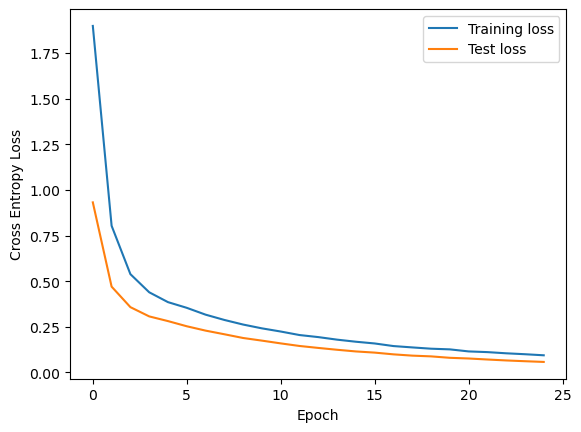

In [34]:
plt.plot(train_loss, label = 'Training loss')
plt.plot(test_loss, label = 'Test loss')
plt.xlabel('Epoch')
plt.ylabel('Cross Entropy Loss')
plt.legend(frameon = True)

In [ ]:
torch.save(model, 'mnist_handwritten_model.pt')
torch.load('mnist_handwritten_model.pt')

In [82]:
import glob
from PIL import Image
img = Image.open('./data/test_1.png').convert('L')

img = np.resize(img, (1,784))
im2arr = ((np.array(img) / 255) - 1) * -1

test_data = torch.Tensor(im2arr)
pred = model(test_data)

print('Prediction: ', torch.argmax(pred, 1).item())

[[-0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0. -0.
  -0. -0. -0. -0. -0. -0. -0. -0. -0. 

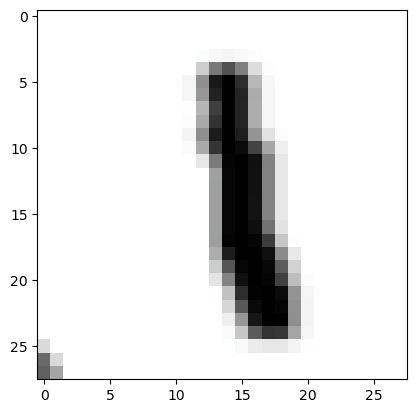

Prediction:  2


In [113]:
import glob
from PIL import Image
img = Image.open('./data/test_1.png')
img_resize = img.resize((int(28), int(28)))

plt.imshow(img_resize, 'gray')
plt.show()

img_resize = np.resize(img_resize, (1,784))
im2arr = ((np.array(img_resize) / 255) - 1) * -1

test_data = torch.Tensor(im2arr)
pred = model(test_data)

print('Prediction: ', torch.argmax(pred, 1).item())

[[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

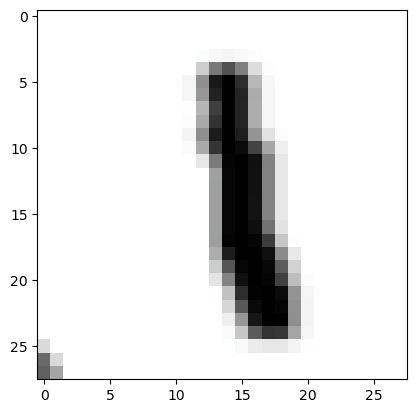

In [140]:
import glob
from PIL import Image
img = Image.open('./data/test_1.png')
img_resize = img.resize((int(28), int(28)))
img_resize = np.resize(img_resize, (1,784))

img_resize = [[0 if num==255 else 255 for v in img_resize for num in v]]

print(img_resize)
img_resize = img.resize((int(28), int(28)))
plt.imshow(img_resize)
plt.show()